# Group 1 - Project Report 

*By Sylvia Ying, Xiaolei Lin, and Erin Kang*

## Introduction
Attending university is an important stage of one’s academic journey. However, not every student obtains a degree, in which their dropout can be caused by a variety of factors. Predicting chances for academic success can be vital for the future of both the student and university in considering whether the student should continue their studies. The dataset “Predict students' dropout and academic success” created from a study done in 2008 to 2019 in Europe contains different factors, such as students’ sex, grades, nationality, and parents’ qualifications, that may contribute towards students’ status of becoming a graduate or a dropout. 

Grades were measured from 0 to 20, where 20 indicates 100%, and grades between 0 to 10 were not given. Hence, students were  either given a grade of 0 or a grade higher or equal to 10 (50%).   Using this dataset, the goal is to see if students’ gender, age at enrollment, first year’s first and second semester grades are collectively a good predictor in determining the academic status of university students (graduate or dropout).  

## Process

We loaded the necessary packages for our analysis.  

In [1]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We read the data into R and tidied and wrangled it by converting the ‘Target’ vector to a factor from a character, choosing only the predictors of interest, and renaming them into more human-readable forms. We also eliminated the "Enrolled" observation under the "Target" column, as they represented individuals still in schooling who do not have a status of being a dropout or graduate. 

In [2]:
data_set<- read_csv("https://raw.githubusercontent.com/ekang27kc/dsci100-2023-T2-Group01-project/main/dataset.csv")
my_data <- data_set |> 
    select(`Gender`, `Age at enrollment`, `Curricular units 1st sem (grade)`, 
           `Curricular units 2nd sem (grade)`, `Target`) |>
    filter(Target != "Enrolled") |>
    mutate(Target = factor(Target, levels = c("Dropout", "Graduate")))
colnames(my_data) <- c('gender', 'enrollment_age', 'first_semester_grade', 'second_semester_grade', 'status') # rename

head(my_data)

Rows: 4424 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Target
dbl (34): Marital status, Application mode, Application order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,enrollment_age,first_semester_grade,second_semester_grade,status
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,20,0.00000,0.00000,Dropout
1,19,14.00000,13.66667,Graduate
1,19,0.00000,0.00000,Dropout
0,20,13.42857,12.40000,Graduate
0,45,12.33333,13.00000,Graduate
1,50,11.85714,11.50000,Graduate


_<span style="color:gray">**Table 1:** Tidied and wrangled dataframe of “Predict students' dropout and academic success” dataset.</span>_

We set the seed for the analysis to be reproducible, and split the tidied data set into a training and testing dataset. 

In [3]:
set.seed(1)

data_split <- initial_split(my_data, prop = 0.75, strata = status)
data_train <- training(data_split)   
data_test <- testing(data_split)

### Preliminary Analysis

_<span style="color:gray">**Table 2:** General statistical information about dataset.</span>_

In [4]:
summary_table <- data_train |>
    group_by(status) |>
    summarize(status_count = n(),
              female_count = sum(gender == 0),
              male_count = sum(gender == 1),
              mean_enrollment_age = mean(enrollment_age, na.rm = TRUE),
              mean_first_semester_grade = mean(first_semester_grade, na.rm = TRUE),
              mean_second_semester_grade = mean(second_semester_grade, na.rm = TRUE),
              missing_data = sum(is.na(enrollment_age), is.na(first_semester_grade), is.na(second_semester_grade)))
summary_table

status,status_count,female_count,male_count,mean_enrollment_age,mean_first_semester_grade,mean_second_semester_grade,missing_data
<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
Dropout,1065,547,518,26.15681,7.328979,5.812974,0
Graduate,1656,1229,427,21.76208,12.594641,12.635296,0


To visualize the density distribution of dropouts and graduates by enrollmenet age, we created a density plot.\
From the graph, we can see that both density curves are right skewed. The curve for graduates shows that the majority of students who graduated enrolled in their late 10s to early 20s, which supports the idea of taking age as a predictor in our classification.

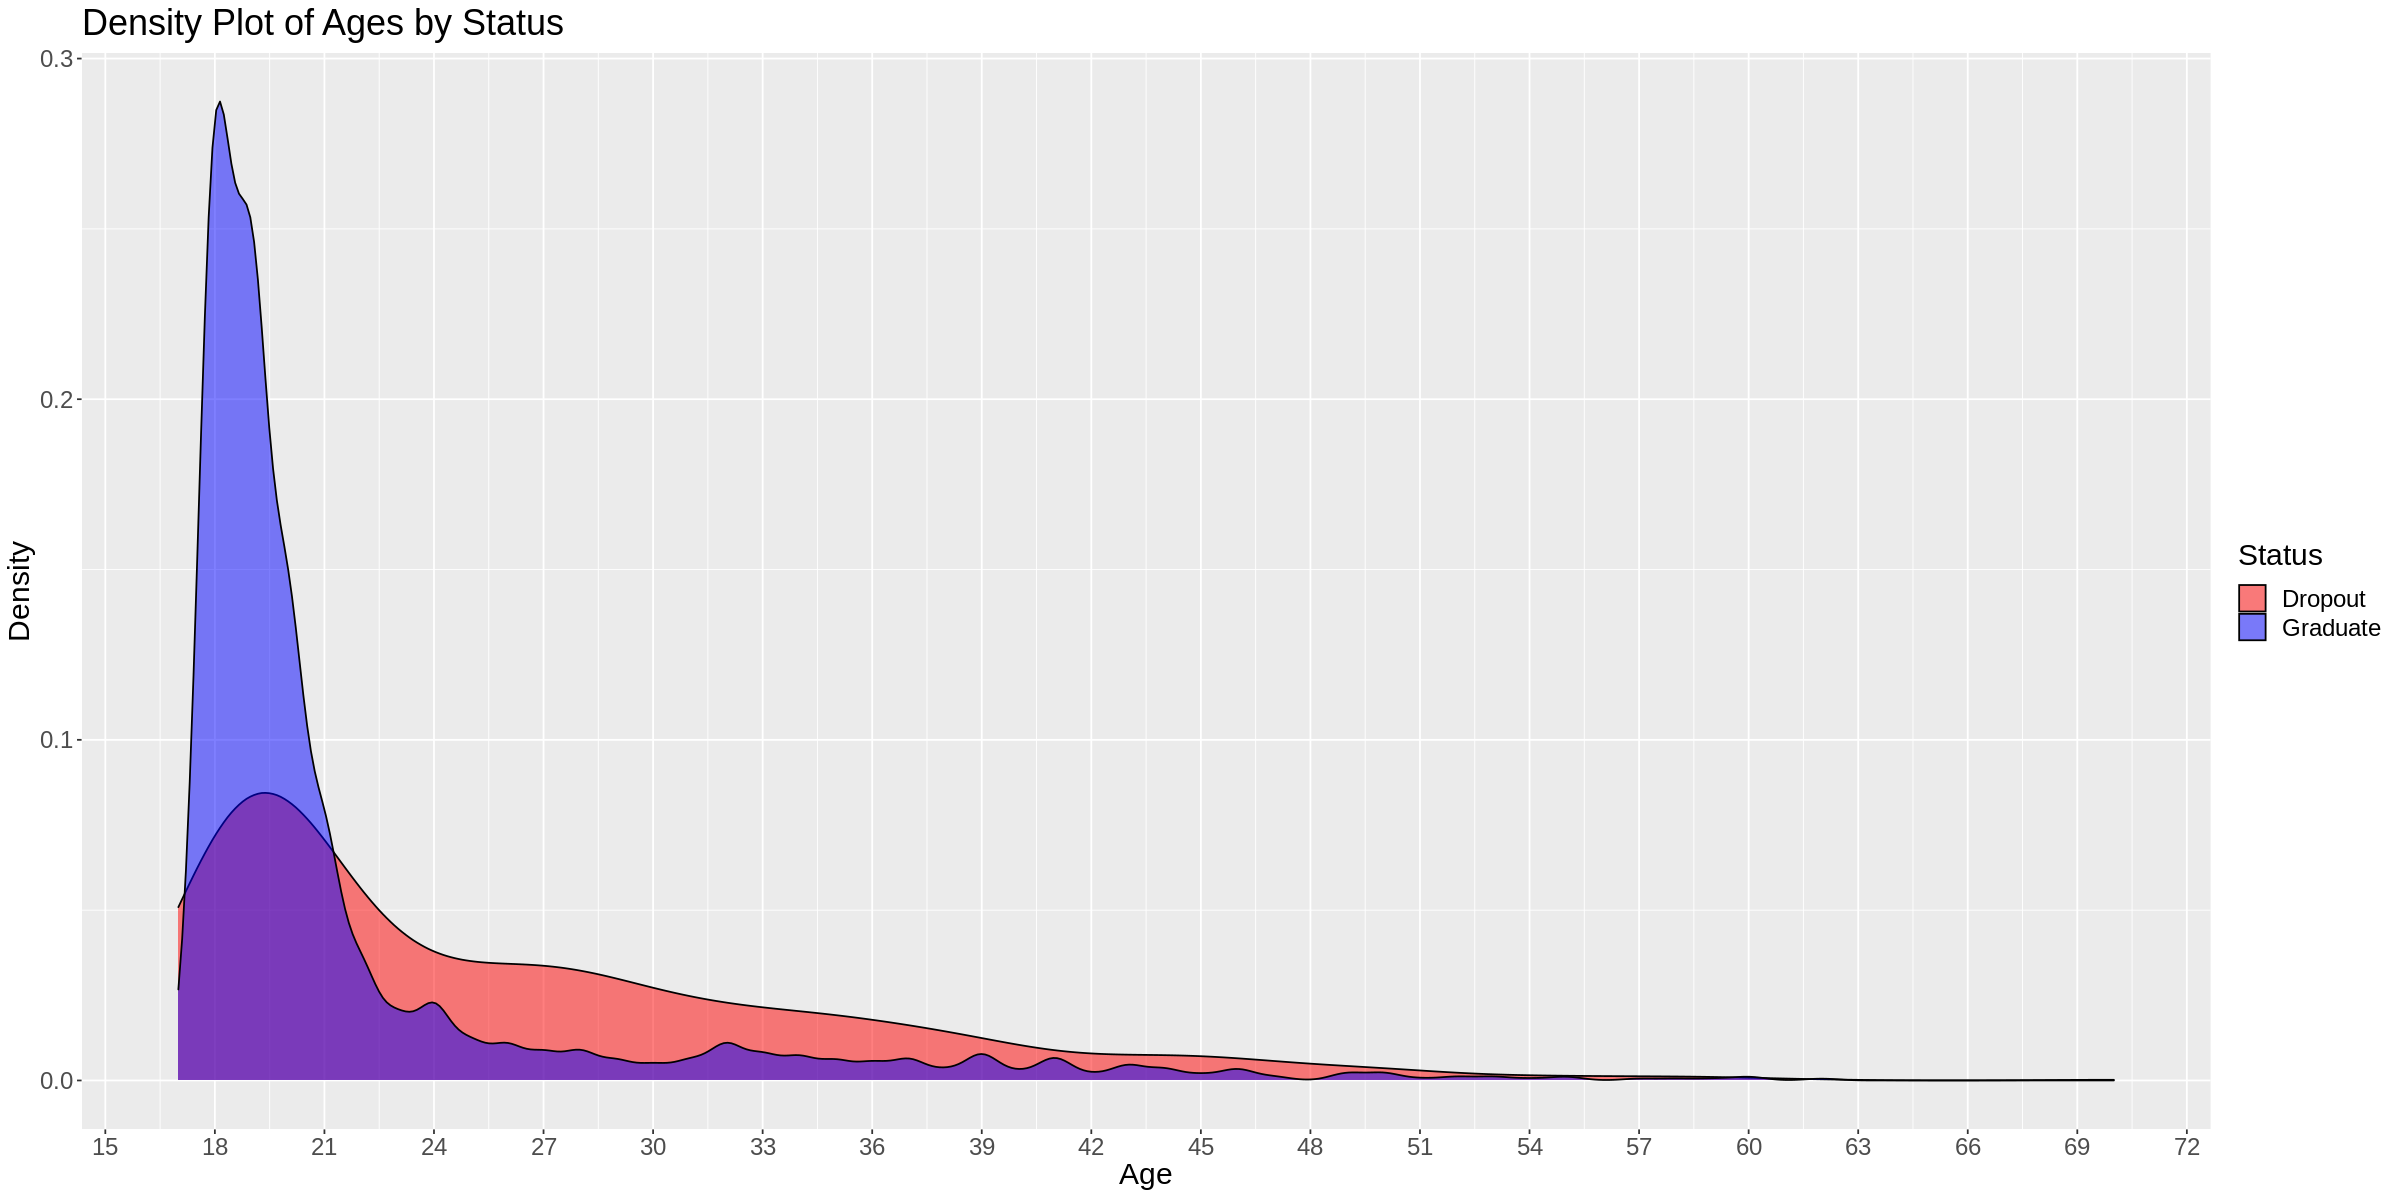

In [12]:
options(repr.plot.width = 20, repr.plot.height = 10)

figure_1 <- ggplot(data_train, aes(x = enrollment_age, fill = status)) + 
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c("red", "blue")) +
  labs(title = "Density Plot of Ages by Status", x = "Age", y = "Density", fill = "Status") +
  scale_x_continuous(breaks = seq(15, 75, 3)) + 
  theme(text = element_text(size = 18), plot.caption = element_text(size = 18))

figure_1

<span style="color:gray">**Figure 1:** Density plot of enrollment age and status (dropout or graduate). </span>
<br>

To visualize the relationship between first semester grades and enrollmenet age by academic status, we created a scatter plot.

We can seen that a great proportion of the students in the age group of late 10s to early 20s were graduates, as shown by the highly concentrated blue dots in that age range, while a smaller proportion of individuals were graduates at an age greater than the mid-20s as shown by the less concentrated blue dots. This shows that there is a relationship between age at enrollment and academic status, where if one is a graduate, they are likely to have enrolled at an age between the late 10s to the early 20s. 

The first-semester grades generally slightly decrease as age increase, showing that there is a relationship between age and first semester grades. Also, it seems that students in their late 10s and early 20s who receive a grade of zero in the first semester still manage to graduate, while those past the age of mid-20s become dropouts.

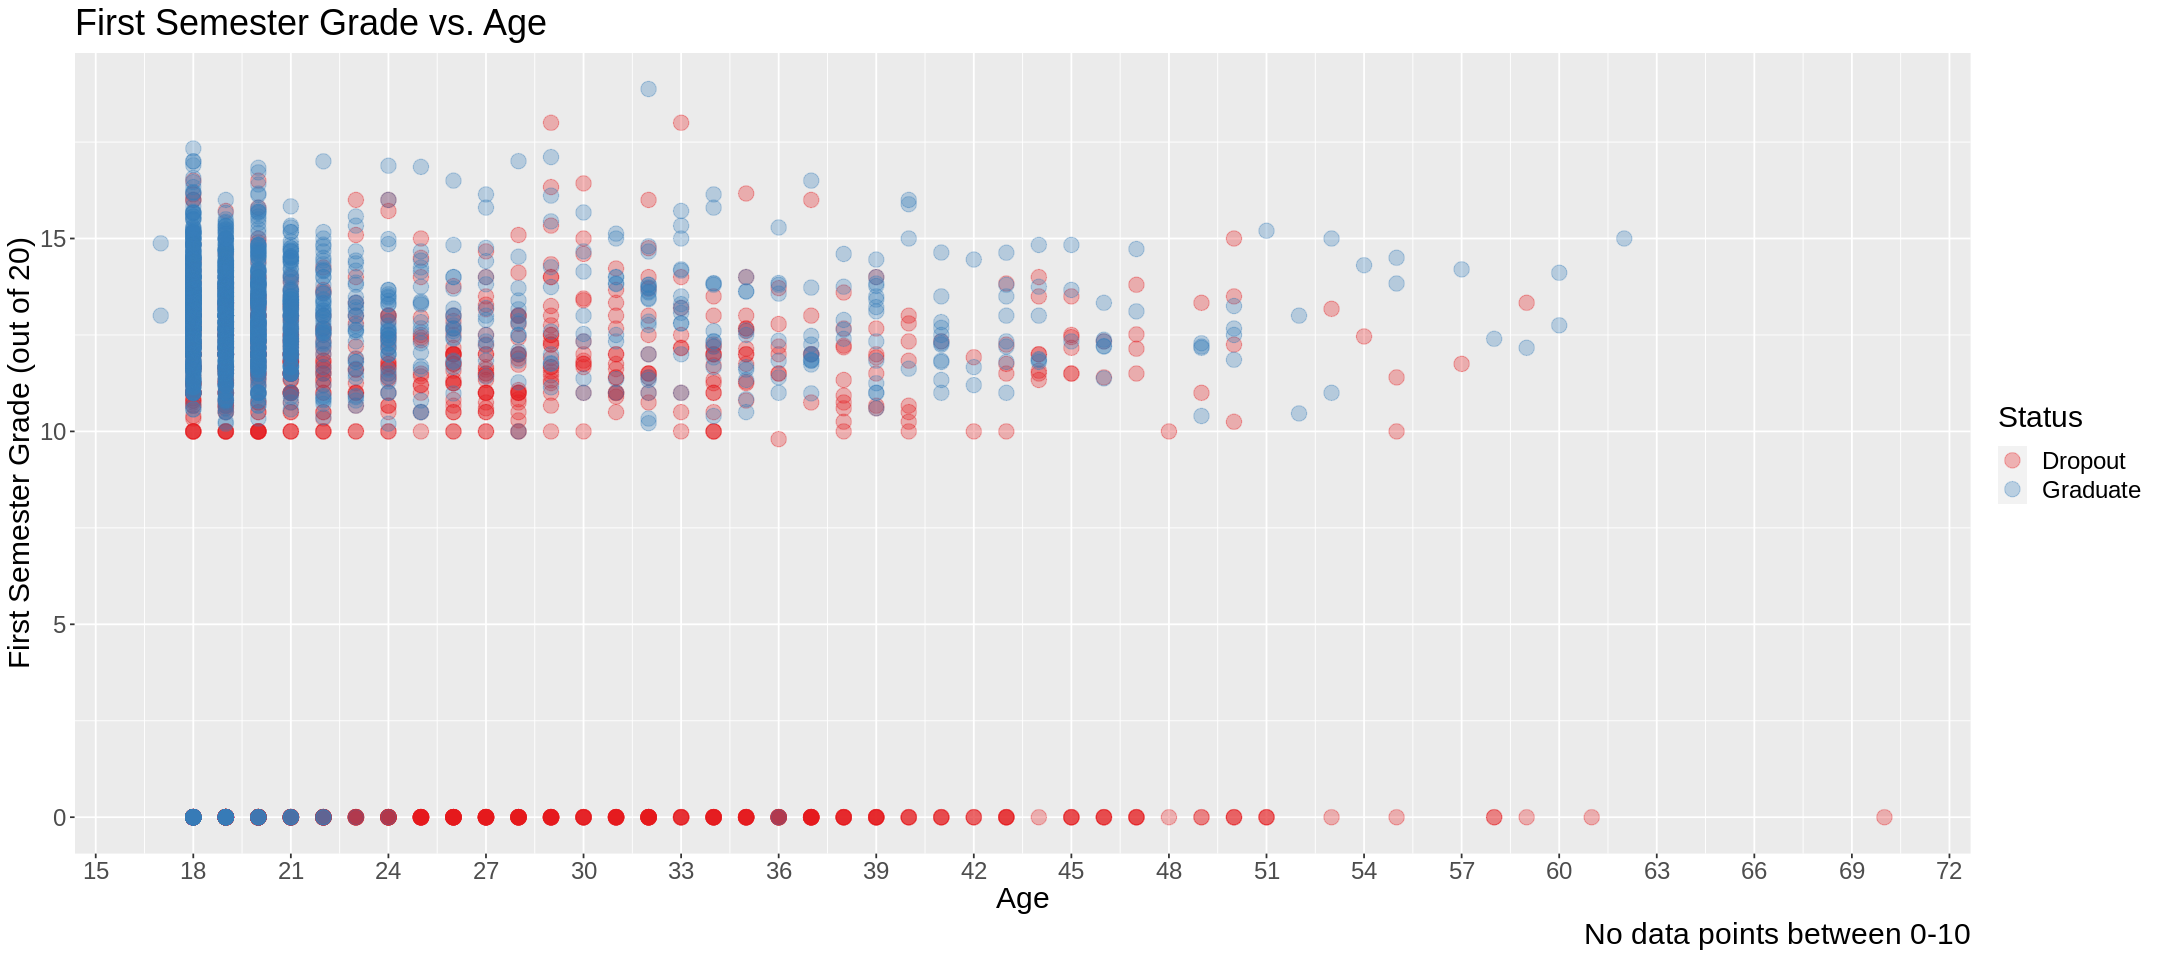

In [10]:
options(repr.plot.width = 18, repr.plot.height = 8)

figure_2 <- ggplot(data_train,
                   aes(x = enrollment_age, y = first_semester_grade, colour = status)) +
                           geom_point(alpha = 0.3, size = 4) +
                           labs(x = "Age", y = "First Semester Grade (out of 20)", title = "First Semester Grade vs. Age",
                                colour = "Status", caption = "No data points between 0-10") +
                           scale_color_brewer(palette = "Set1")+
                           scale_x_continuous(breaks = seq(15, 75, 3)) + 
                           theme(text = element_text(size = 18), plot.caption = element_text(size = 18))

figure_2 

_<span style="color:gray">**Figure 2:** The relationship between enrollment age and first semester grade by academic status.</span>_ 

Similar to the previous analysis, to find the relationship between second semester grades and enrollmenet age by status, we created another scatter plot.

Similar to the previous analysis, blue dots are more concentrated in the age range of late 10s to early 20s, while the concentration is less when age is greater than the mid-20s. Again, this shows that there is a relationship between enrollment age and academic status, where if one is a dropout, they are likely to have been enrolled at an age past the mid-20s. 

Again, the general trend of the second-semester grades slightly decrease as age increase, showing that there is a relationship between age and second semester grades. Also, it seems that students in their late 10s and early 20s who receive a grade of zero in the first semester still manage to graduate, while those past the age of mid-20s were dropouts. 

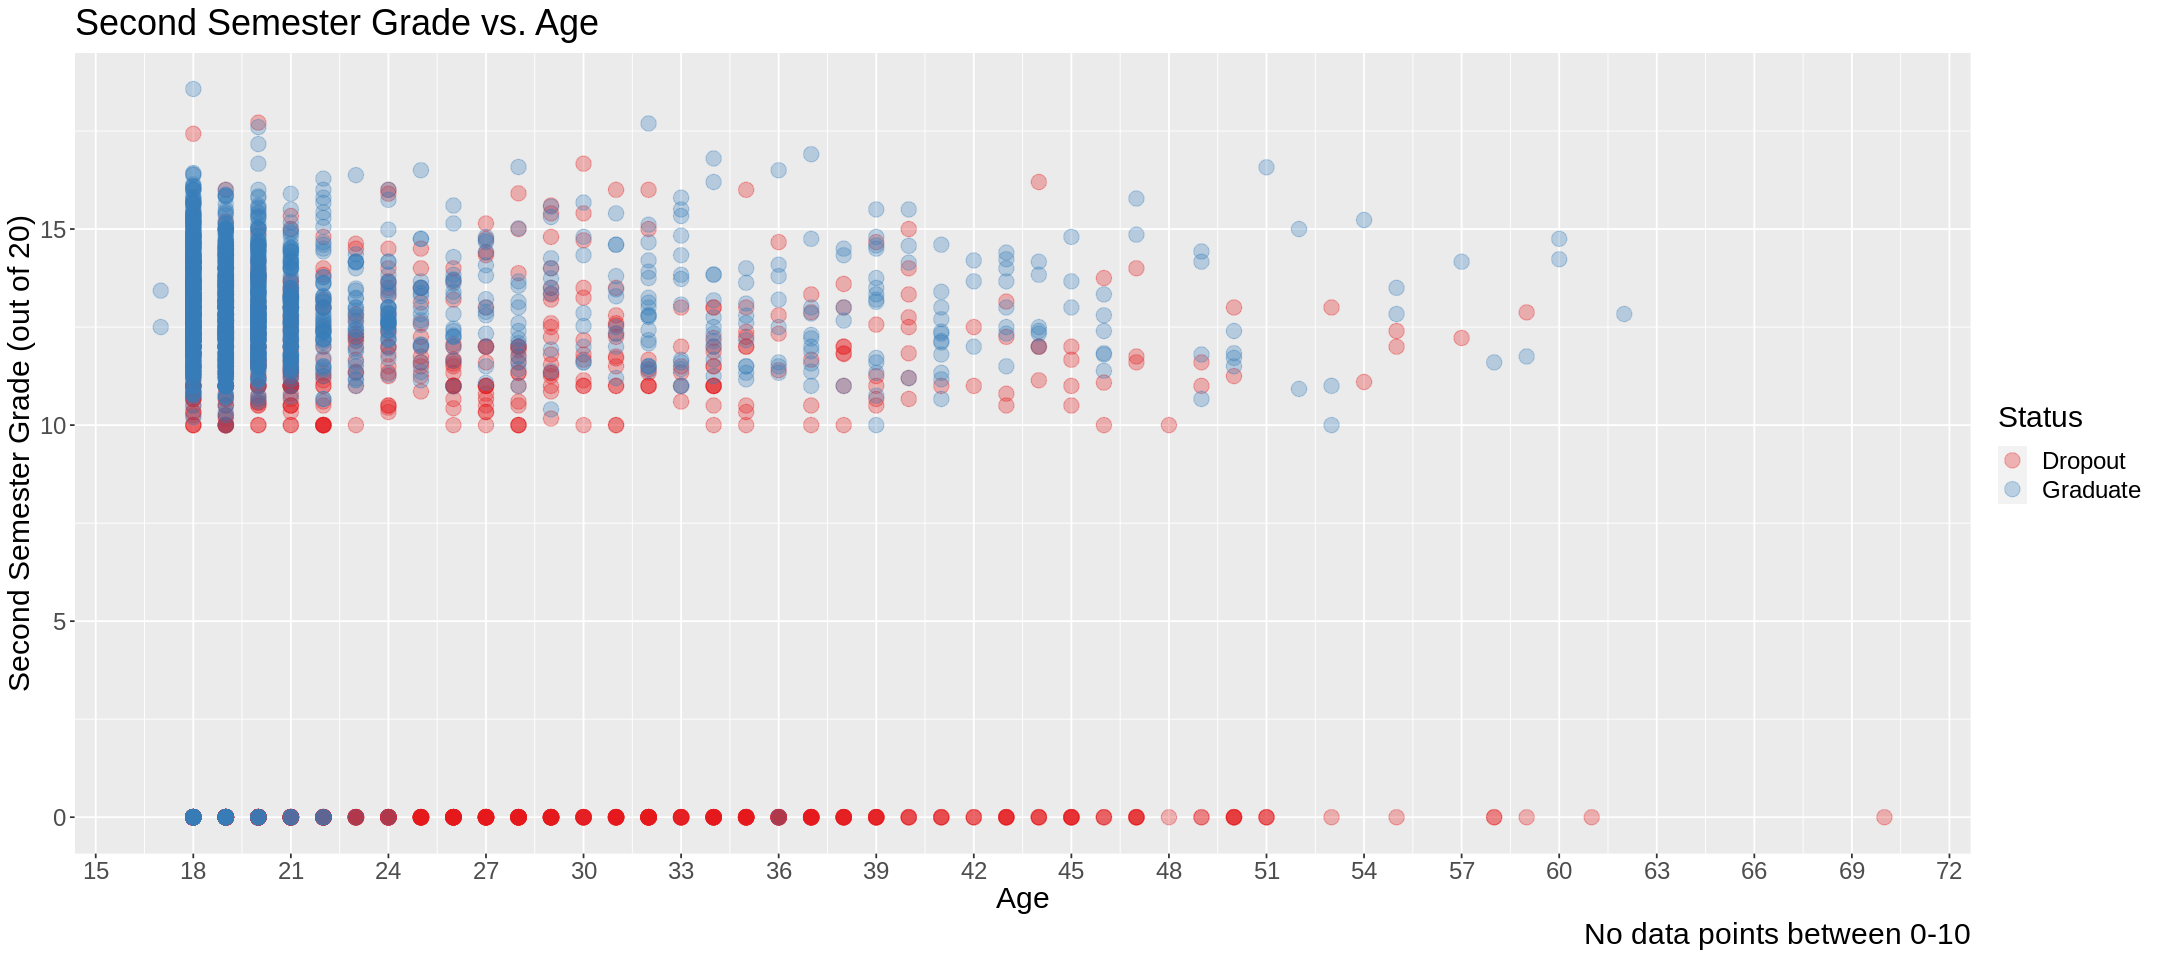

In [9]:
options(repr.plot.width = 18, repr.plot.height = 8)

figure_3 <- ggplot(data_train,
                   aes(x = enrollment_age, y = second_semester_grade, colour = status)) +
                           geom_point(alpha = 0.3, size = 4) + 
                           labs(x = "Age", y = "Second Semester Grade (out of 20)", title = "Second Semester Grade vs. Age",
                                colour = "Status", caption = "No data points between 0-10") +
                           scale_color_brewer(palette = "Set1") +
                           scale_x_continuous(breaks = seq(15, 75, 3)) + 
                           theme(text = element_text(size = 18), plot.caption = element_text(size = 18))

figure_3 

_<span style="color:gray">**Figure 3:** Relationship between enrollment age and second semester grade by academic status.</span>_ 

To find the relationship between the mean grade and enrollmenet age by status, we created a scatter plot. 

The concentration of blue dots follow the trend observed in the two previous plots, indicating that there is a relationship between enrollment age and academic status. Again, the general trend in grades and age shown in the previous two scatter plots are shown here, indicating that there is a relationship between the two predictors. Individuals in the age group of late 10s to early 20s graduated with a mean grade of zero, while those past the age of the mid 20s were dropouts. Also, mostly all individuals who received a mean grade between zero and 10 (0-50%) were dopouts. 

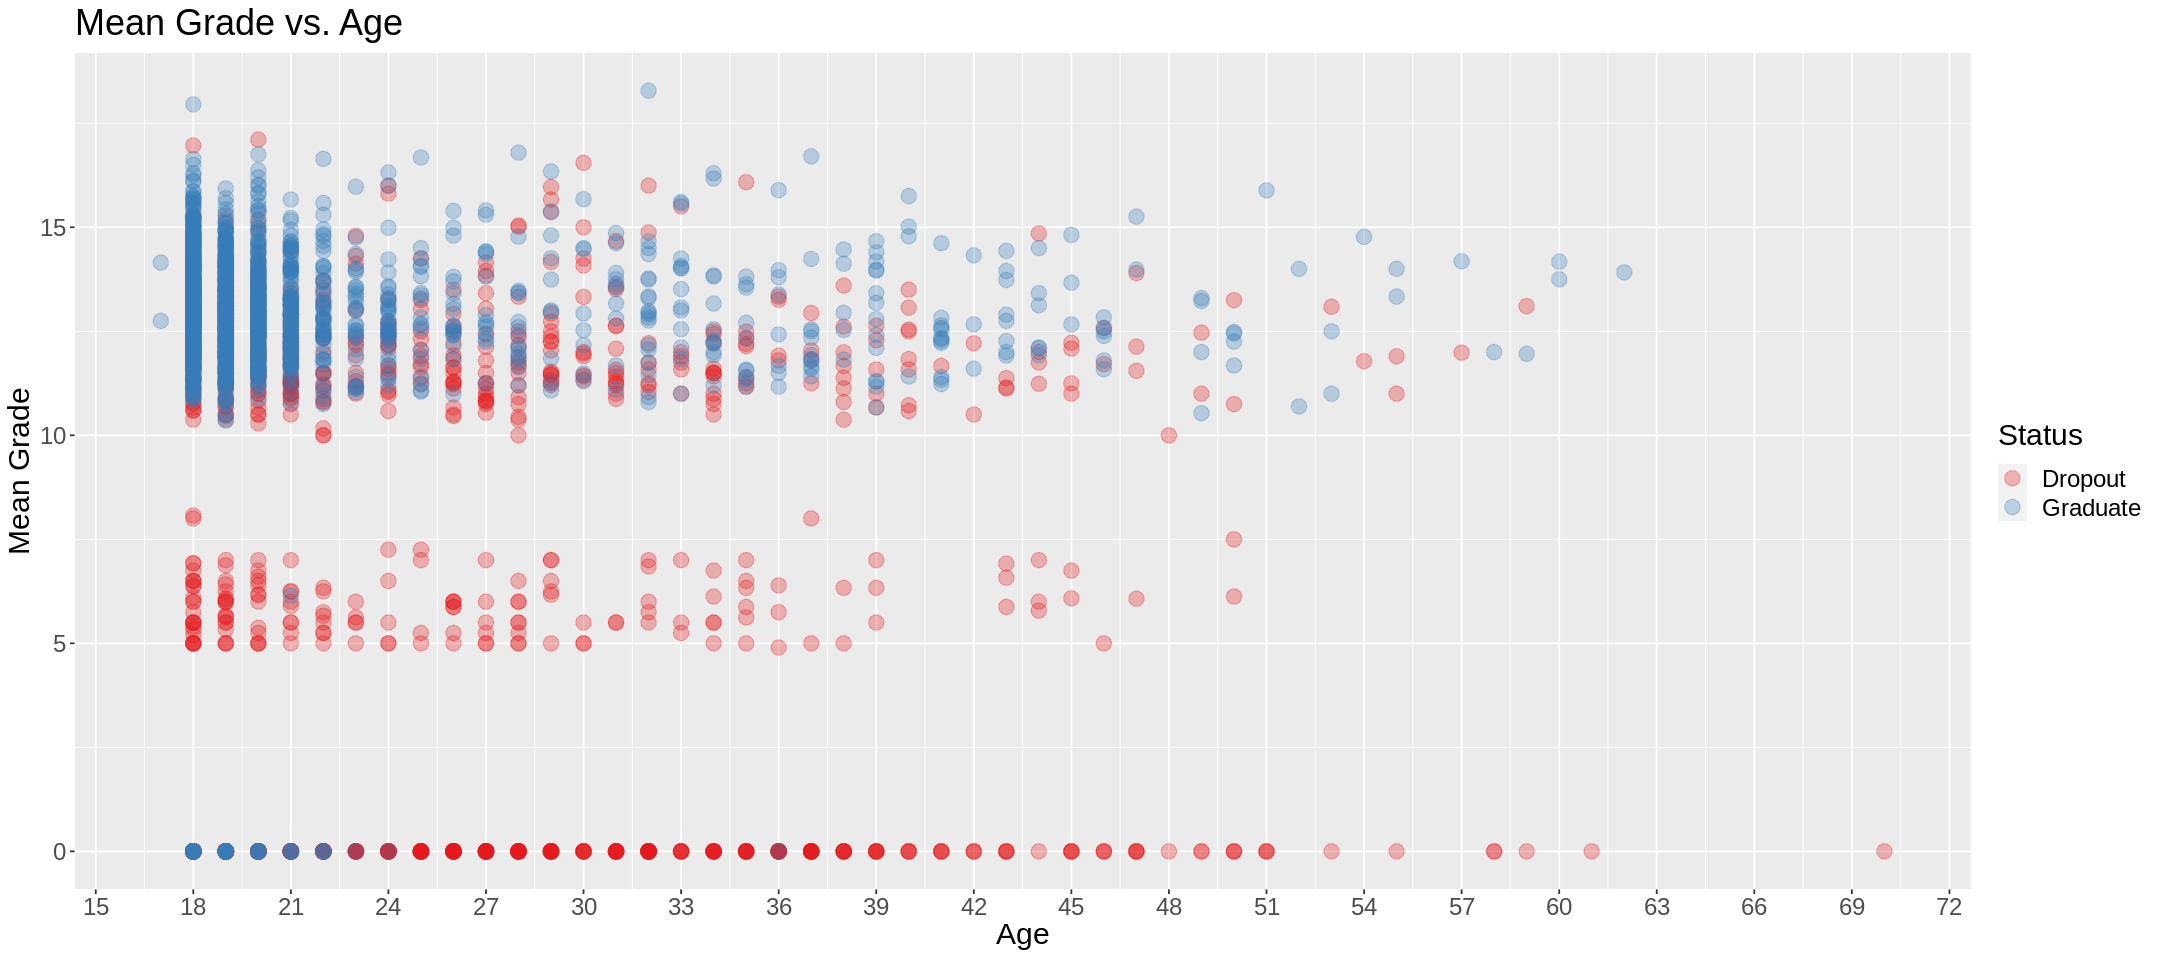

In [14]:
options(repr.plot.width = 18, repr.plot.height = 8)

figure_4 <- data_train |>
    mutate(mean_sem_grade = (first_semester_grade + second_semester_grade) / 2) |>
    ggplot(aes(x = enrollment_age, y = mean_sem_grade, colour = status)) +
    geom_point(alpha = 0.3, size = 4) +
    labs(x = "Age", y = "Mean Grade", title = "Mean Grade vs. Age",
         colour = "Status") +
    scale_color_brewer(palette = "Set1")+
    scale_x_continuous(breaks = seq(15, 75, 3)) + 
    theme(text = element_text(size = 18))

figure_4

_<span style="color:gray">**Figure 4:** Relationship between enrollment age and mean first year grade (average of first and second semester grades) by academic status.</span>_ 

In [20]:
zero_grade_count <- data_train |>
  group_by(status) |>
  summarize(first_semester_zero = sum(first_semester_grade == 0),
            second_semester_zero = sum(second_semester_grade == 0))

total_first_semester_zero <- sum(data_train$first_semester_grade == 0)
total_second_semester_zero <- sum(data_train$second_semester_grade == 0)

zero_grade_count <- zero_grade_count |>
  add_row(status = "Total",
          first_semester_zero = total_first_semester_zero,
          second_semester_zero = total_second_semester_zero)

zero_grade_count

status,first_semester_zero,second_semester_zero
<chr>,<int>,<int>
Dropout,420,552
Graduate,64,63
Total,484,615


_<span style=
"color:gray">**Table 3:** The total number of students who had a grade of 0 in the first and second semesters and by academic status. </span>_ \
Based on the information in the table, it appears that a large proportion of students who received a grade of zero in either the first or second semester eventually dropped out. This indicates a strong relationship between receiveing a grade of zero and becoming a drop out. 

To investigate the relationship of first semester grades, second semester grades, and acadamic status, we created a scatter plot excluding the zero grades since it is known for them to be mostly dropouts.

Warning message:
“Removed 631 rows containing missing values (geom_point).”


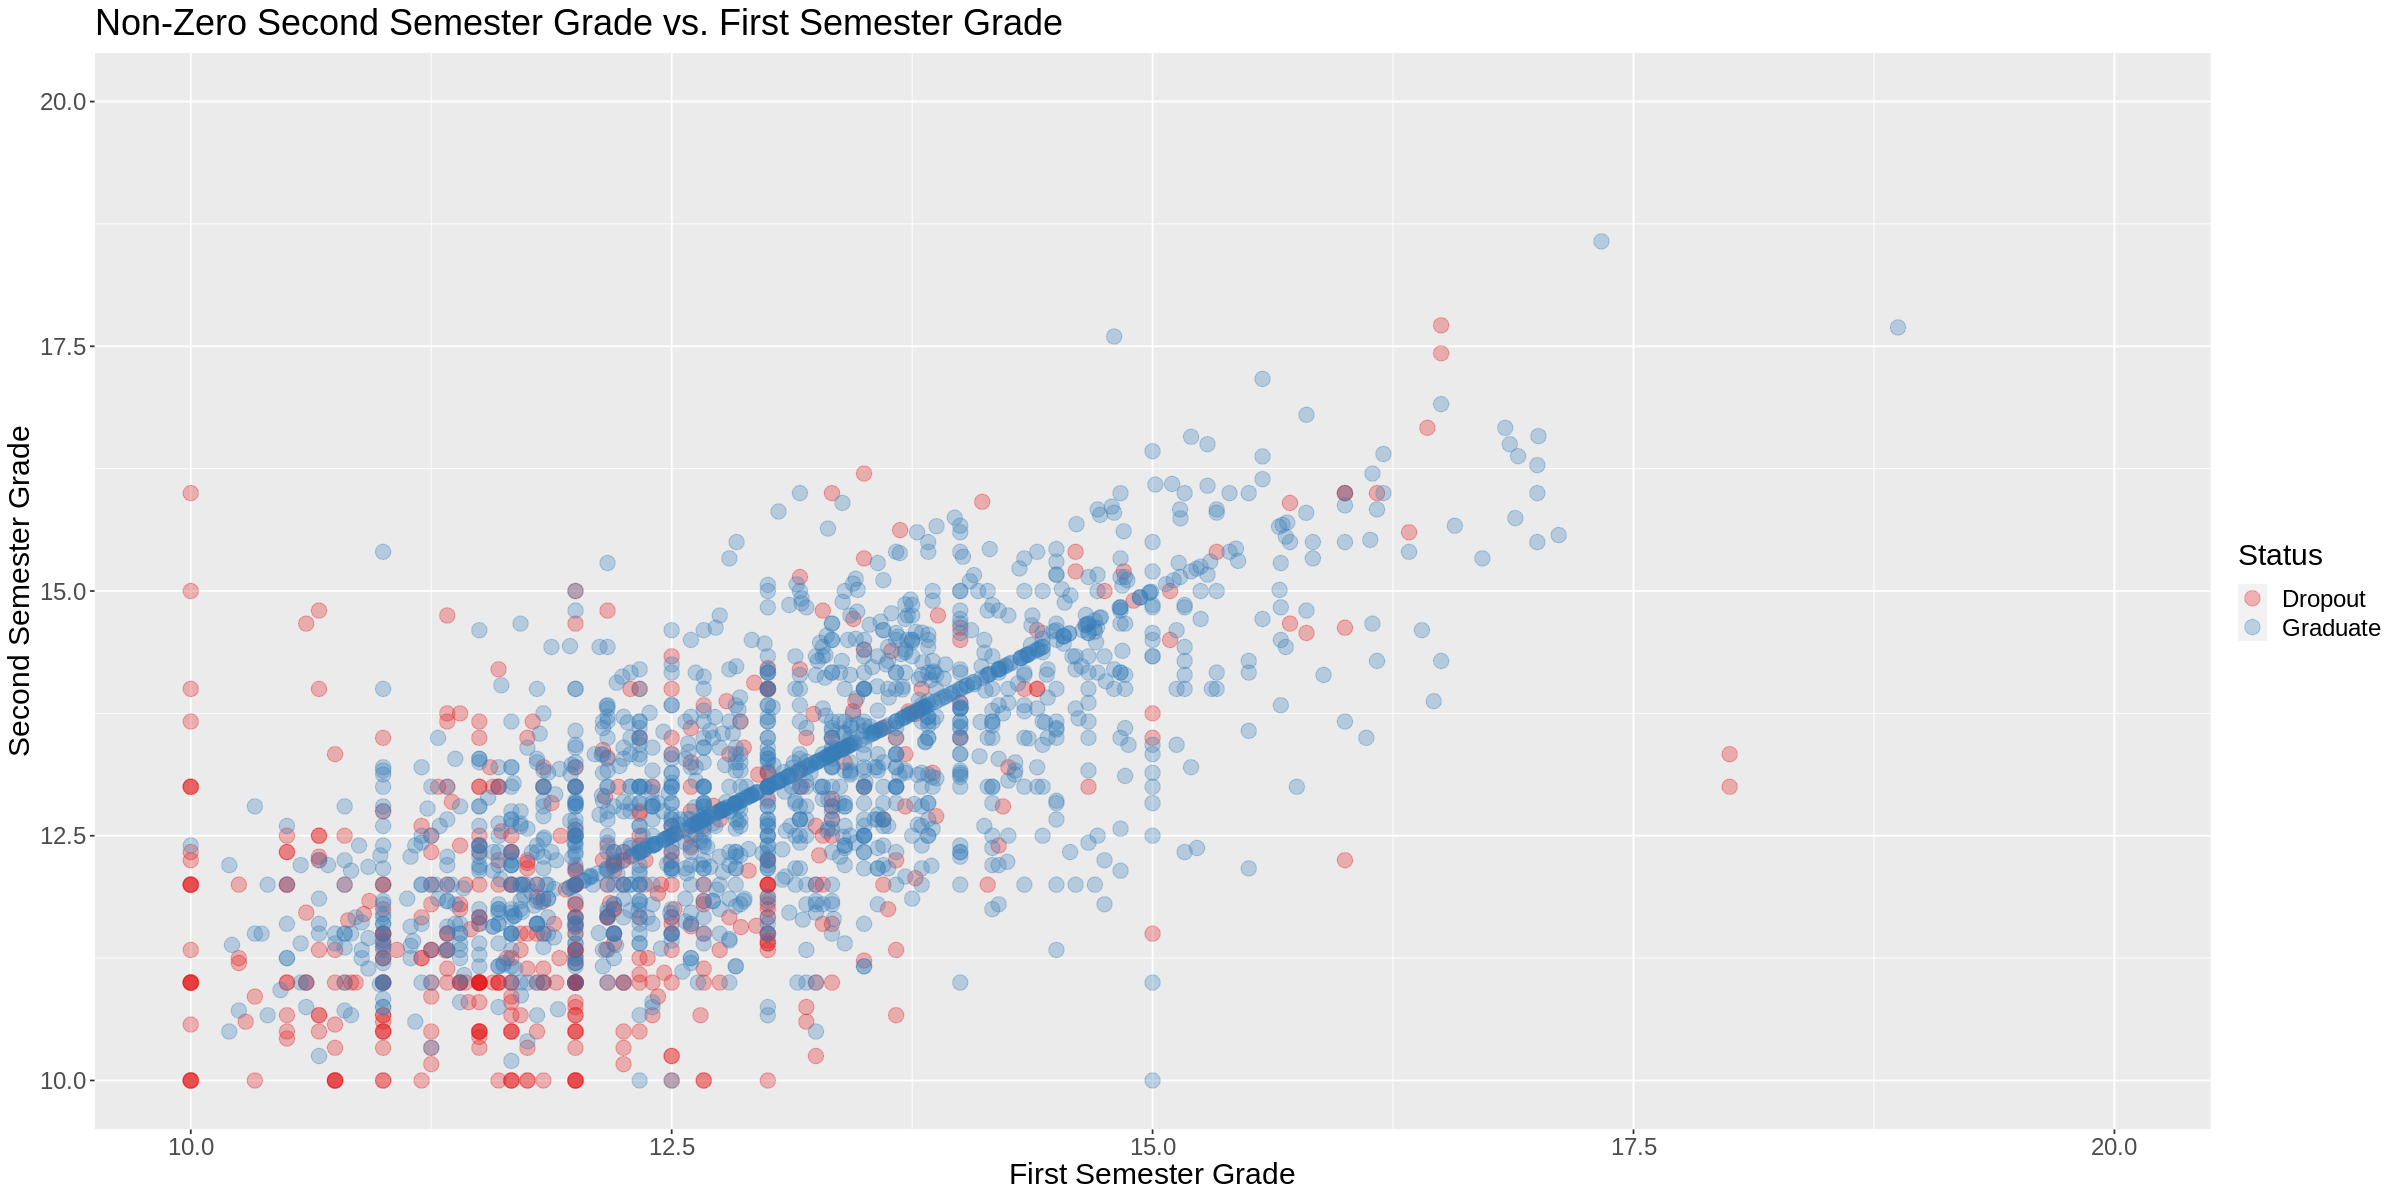

In [21]:
options(repr.plot.width = 20, repr.plot.height = 10)

grade_plot <- data_train |>
    ggplot(aes(x = first_semester_grade, y = second_semester_grade, colour = status)) +
    geom_point(alpha = 0.3, size = 4) +
    labs(x = "First Semester Grade", y = "Second Semester Grade", 
         title = "Non-Zero Second Semester Grade vs. First Semester Grade",
         colour = "Status") +
         ylim(c(10, 20)) +
         xlim(c(10, 20)) +
         scale_color_brewer(palette = "Set1") +
    theme(text = element_text(size = 18))

grade_plot

_<span style="color:gray">**Figure 5:** The relationship between first semester and second semester grades by academic status. </span>_

To visualize the proportion of graduates by sex, 

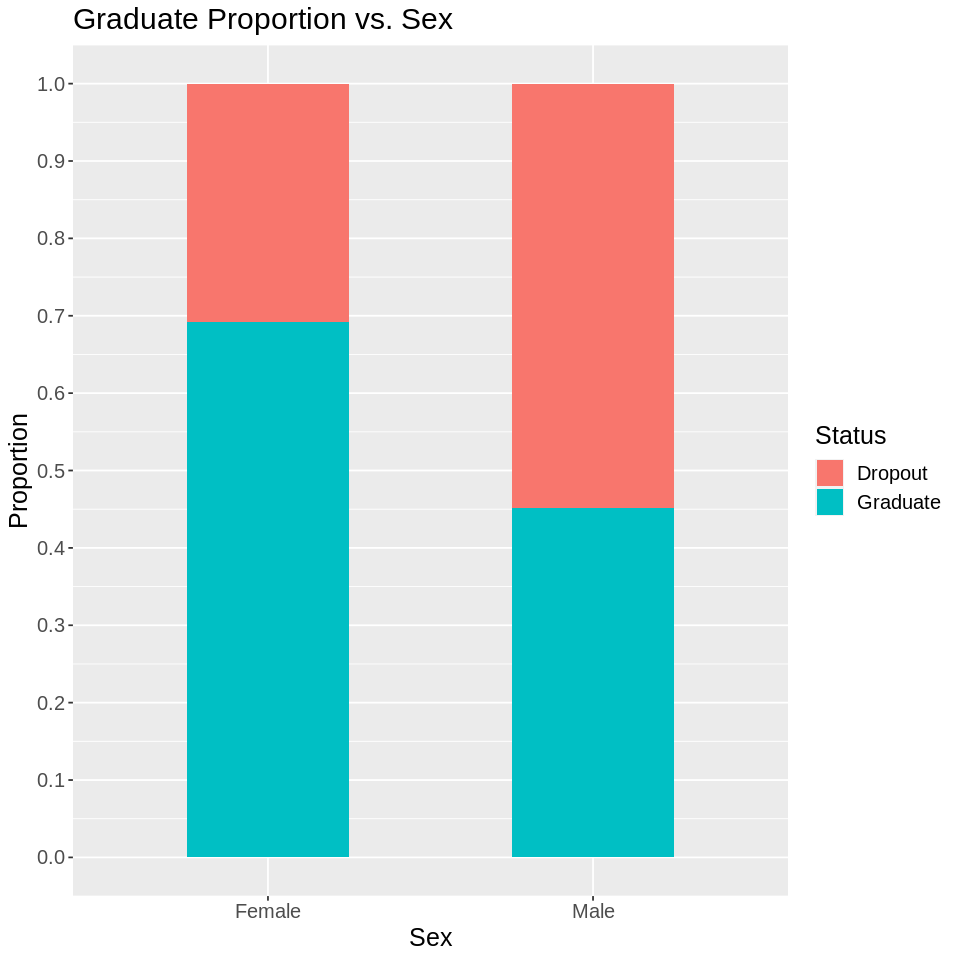

In [22]:
options(repr.plot.width = 8, repr.plot.height = 8)

proportion_bar_plot <- data_train |>
   mutate(gender = factor(gender, levels = c("0", "1"), labels = c("Female", "Male"))) |>
   ggplot(aes(x = gender, fill = status)) + 
   geom_bar(position = 'fill', width = 0.5) + 
   xlab("Sex") +
   ylab("Proportion") +
   labs(fill = "Status") +
   ggtitle("Graduate Proportion vs. Sex") +
   scale_y_continuous(breaks = seq(0, 1, 0.1)) + 
   theme(text = element_text(size = 15))

proportion_bar_plot

_<span style="color:gray">**Figure 6:** Proportion of dropout and graduate academic statuses by sex. </span>_

## Methods
#### Choosing Predictors:
Four characteristics that may predict whether an individual will be a graduate or a dropout were chosen.

`Sex` - Studies have shown that females are more likely to graduate than males.<sup> 1, 2</sup>

`Age at Enrollment` - The opportunity cost for older students is higher and may likely lead to the choice of dropping out than a younger individual.<sup> 3</sup>

`1st & 2nd Semester Grades (2 predictors)` - Grades could be a predictor, as low grades can result in students choosing to drop out. Changes in grades from first to second semester could also influence students' decision of dropping out.  

The goal is to see if these predictors predict whether an individual will graduate or drop out and how well they predict it.

First, we created a recipe, specifying the interested class (status) and predictors' columns and standardizing the training dataset by scaling and centering our observation values.

In [ ]:
data_recipe <- recipe(status ~ . , data = data_train)|>
step_scale(all_predictors())|>
step_center(all_predictors())

We then made a model specification, telling R to use the K-nearest-neighbor algorithm and tune the model with mulitple different numbers of nearest neighbors (k). 

In [ ]:
data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
set_engine("kknn")|>
set_mode("classification")

We made a 5-fold cross validation for our training dataset to obtain a better estimate of the model's accuracy for each k value used. 

In [ ]:
set.seed(1)

data_vfold <- vfold_cv(data_train, v = 5, strata = status)

We created a tibble of all the k values we wanted the model to try. 

In [ ]:
k_vals <- tibble(neighbors = seq(from = 1, to = 200, by = 2))

We created a workflow where the model specification and recipe were fit into each classification model with differnt k values (1-200 by 2s). 

In [ ]:
data_fit <- workflow()|>
add_model(data_spec)|>
add_recipe(data_recipe)|>
tune_grid(resamples = data_vfold, grid= k_vals)

We collected the estimated accuracies of each classifier to determine the best number of neighbours for our model by picking the classifier with the highest estimated accuracy. 

In [ ]:
data_accuracies<-data_fit|>
collect_metrics()|>
filter(.metric == "accuracy")

With a dataframe of each classifier's estimated accuracies, we plotted a line graph showing the estimated accuracies according to the number of neighbors used. This helped us better visualize each models' estimated accuracies and gave a ballpark of the k value that would result in a model with the highest accuracy.

In [ ]:
options(repr.plot.width= 15., repr.plot.height=5)

neighbor_accuracy_plot<- ggplot(data_accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Numer of Neighbors (k)", y = "Estimated Accuracy") +
                  ggtitle("Estimated Accuracy Vs Number of Neighbors")+
                  theme(text = element_text(size = 20)) 
neighbor_accuracy_plot

_<span style="color:gray">**Figure 6:** Estimated accuracy of the model using K values of 1 to 200 by 2s. The highest peak occured when the k value was around 20.</span>_

We used the accuracy data set and arranged it in descending order by the estimated accuracy to select the k value that produced a model with the highest accuracy. We did this by slicing the first row of the dataframe and pulling the k value from the `neighbors` column.  

In [ ]:
data_accuracies|> 
arrange(desc(mean))|>
slice(1)|>
pull(neighbors)

The k value that produced the highest estimated accuracy of the classification model was when k=19. 

We retrained our training dataset with the best k value by specifying the KNN algorithm to use 19 closest data points to obtain the highest accuracy model. 

In [ ]:
data_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbor = 19)|>
set_engine("kknn")|>
set_mode("classification")

Using the recipe created before and the newly created model specification, we created a new workflow to better train our model and enhance our prediction accuracy.  

In [ ]:
data_best_fit <- workflow()|>
add_model(data_spec_best)|>
add_recipe(data_recipe)|>
fit(data_train)

We tested the trained model on our testing dataset to evaluate the performance of the model by obtaining the `status` predictions the model made and the true `status` in the testing data. 

In [ ]:
predictions<- predict(data_best_fit, data_test)|>
bind_cols(data_test)

We then collected the model's statistics' accuracy value using `metrics()` to see how accurately the model performed.

In [ ]:
data_metrics<- predictions|>
metrics(truth = status, estimate = .pred_class)|>
filter(.metric == "accuracy")
data_metrics

_<span style="color:gray">**Table 3:** Estimated accuracy of the classification model was determined to be 82.18%. </span>_

Finally, we created a confusion matrix to see how many of the predicted values aligned with the actual values from the testing dataset. Using the matrix, we also observed what the model specfically predicted right and wrong based on how many times the model predicted the students' `status` correctly and incorrectly.

In [ ]:
data_conf_mat<- conf_mat(predictions, truth=status, estimate=.pred_class)
data_conf_mat

_<span style="color:gray">**Table 4:** A confusion matrix of the model's predictions and the true status showing the type of predictions the model made and the number of times it predicted correctly and incorrectly. </span>_

## Discussion

As shown in Table 3, it was found that our classification model was quite accurate, having an accuracy of 82.18% when tested on our testing dataset. This is as expected since the chosen predictors are known to be related to whether a student is likely to graduate or drop out as shown in our preliminary analysis and previous studies. Hence, this classification may be useful for predicting whether or not a student will graduate or become a dropout in the future of their academic studies. 

For students from one perspective, a prediction of being a dropout may motivate an individual in their studies, and others with a prediction of being a graduate may be encouraged to keep up with their work. On the flip side, a dropout status prediction may discourage the individual from trying any harder and nudge them into actually considering dropping out, and a graduate status prediction may reassure individuals enough to prevent them from pushing themselves to reach a higher grade. 

For teachers, this classification model may help them note which students may be more difficult to graduate and invest more time and energy in helping them in their studies. 

For universities, this model can help them identify how many of their students are likely to be graduates and dropouts and plan their courses, programs, and activities accordingly. For example, if many of the students are likely to become dropouts, universities may start promoting academic programs, clubs, and workshops to help them in their studies. Another example is determining if it is worth the time, effort, and money for a student to continue in their schooling. Using our classification model, students may think twice on the costs of continuing in university when given a dropout status. 

However, note that the predictors for grades were based only on the first and second semesters of the first year. No matter how accurate our model is, we never know how students’ grades may have changed throughout the years till graduation. A lot of changes in terms of grades, both positive and negative, may have occurred. Hence, we shouldn’t trust the model’s predictions too much and, as a student, be worry-free when given a graduate status, nor be discouraged and lose hope when given a dropout status.  

Additionally, classes with similar ages, grades, and gender based on the predictors could be made if it would be beneficial to the students graduating. As we can see from Figure 1, all students over the age of around 23 dropped out when they failed the first semester. This could potentially be improved if there was a class catered toward individuals in their late 20s to 30s with a more appropriate learning method for that age group. 

Based on our analysis, further studies could be done to analyze each factor’s significance (sex, age, grades in first and second semesters) in predicting students' future status and determining why certain factor(s) could be more significant than others. Based on the fairly high accuracy of our model, another question would be whether or not this model can be applied to university students outside of Europe. If there is a significant difference in the accuracies of the model, one could also ask which factors are more predictive of a students’ status in different regions of the world and why. 

## References

Dataset: https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention?datasetId=2780494

<sup> 1</sup>  *"The male college crisis is not just in enrollment, but completion\"* (2021)\
https://www.brookings.edu/blog/up-front/2021/10/08/the-male-college-crisis-is-not-just-in-enrollment-but-completion/

<sup> 2</sup> *"Cause Analysis of Students’ Dropout Rate in Higher Education Study Program"* (2014)\
https://doi.org/10.1016/j.sbspro.2013.12.625
 
<sup> 3</sup>   *"The determinants of university dropouts: a bivariate probability model with sample selection"* (2020)\
https://doi.org/10.1016/S0272-7757(00)00029-7